# Supervised Learning with Synthetic Clients

## Import

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

SEED = 42

print("Libraries loaded. sklearn version check:")
import sklearn, sys
print("scikit-learn:", sklearn.__version__, "| Python:", sys.version.split()[0])

Libraries loaded. sklearn version check:
scikit-learn: 1.6.1 | Python: 3.13.5


## Load synthetic pairs

In [2]:
pairs_df = pd.read_csv("synth_pairs_large.csv")

print("Shape:", pairs_df.shape)
print("Label distribution:\n", pairs_df["label"].value_counts())

Shape: (24000, 7)
Label distribution:
 label
1    12000
0    12000
Name: count, dtype: int64


In [3]:
pairs_df.head()

,first_name_left,last_name_left,country_left,first_name_right,last_name_right,country_right,label
0,Luca,Colombo,Italy,Luca,Colombo,Italy,1
1,Chloé,Petit,France,Lena,Weiß,Germany,0
2,Elena,Müller,Switzerland,Hans,Weiss,Switzerland,0
3,Maxime,Hugentobler,Switzerland,François,Hugentobler,Switzerland,0
4,Lukas,Schneider,Germany,Nina,Kraemer,Germany,0


## Train, Val, Test split

In [4]:
# Create short text fields for each side
def make_text_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["name_left"]  = (df["first_name_left"].astype(str)  + " " + df["last_name_left"].astype(str))
    df["name_right"] = (df["first_name_right"].astype(str) + " " + df["last_name_right"].astype(str))
    # Option A (no OHE): also feed country tokens into hashing
    df["country_left_txt"]  = df["country_left"].astype(str)
    df["country_right_txt"] = df["country_right"].astype(str)
    return df

pairs_df = make_text_cols(pairs_df)

# 70/30 first
train_df, temp_df = train_test_split(
    pairs_df, test_size=0.30, stratify=pairs_df["label"], random_state=SEED
)
# 15/15 from the remaining 30%
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df["label"], random_state=SEED
)

print("Split sizes -> Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)
print("Train label distribution:\n", train_df["label"].value_counts(normalize=True).round(3))
print("Val   label distribution:\n", val_df["label"].value_counts(normalize=True).round(3))
print("Test  label distribution:\n", test_df["label"].value_counts(normalize=True).round(3))

Split sizes -> Train: (16800, 11) Val: (3600, 11) Test: (3600, 11)
Train label distribution:
 label
0    0.5
1    0.5
Name: proportion, dtype: float64
Val   label distribution:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64
Test  label distribution:
 label
1    0.5
0    0.5
Name: proportion, dtype: float64


In [5]:
train_df.head()

,first_name_left,last_name_left,country_left,first_name_right,last_name_right,country_right,label,name_left,name_right,country_left_txt,country_right_txt
6732,Pedro,Fernandes,Brazil,Fernanda,Fernandes,Brazil,0,Pedro Fernandes,Fernanda Fernandes,Brazil,Brazil
16403,Ana,Pereira,Brazil,Ana,Pereira,Brazil,1,Ana Pereira,Ana Pereira,Brazil,Brazil
9067,Chiara,Ferrari,Italy,Chiara,Ferrari,Italy,1,Chiara Ferrari,Chiara Ferrari,Italy,Italy
10522,Gustavo,Souza,Brazil,Luísa,Rcoha,Brazil,0,Gustavo Souza,Luísa Rcoha,Brazil,Brazil
15712,Ana,Pereira,Portugal,Inês,Almeida,Portugal,0,Ana Pereira,Inês Almeida,Portugal,Portugal


In [6]:
val_df.head()

,first_name_left,last_name_left,country_left,first_name_right,last_name_right,country_right,label,name_left,name_right,country_left_txt,country_right_txt
53,José,García,Mexico,José,Gacría,Mexico,1,José García,José Gacría,Mexico,Mexico
16923,Käthe,Schäfer,Germany,Käthe,Schäfer,Germany,1,Käthe Schäfer,Käthe Schäfer,Germany,Germany
5445,Laura,López,Spain,José,óGmez,Spain,0,Laura López,José óGmez,Spain,Spain
13570,Pedro,Rodrigues,Portugal,Pedro,Rodrigues,Portugal,1,Pedro Rodrigues,Pedro Rodrigues,Portugal,Portugal
4272,Théo,Laurent,France,Théo,Laurent,France,1,Théo Laurent,Théo Laurent,France,France


In [7]:
test_df.head()

,first_name_left,last_name_left,country_left,first_name_right,last_name_right,country_right,label,name_left,name_right,country_left_txt,country_right_txt
17639,Ana,Pereira,Portugal,nAa,Pereira,Portugal,1,Ana Pereira,nAa Pereira,Portugal,Portugal
3652,Léa,Weiss,Switzerland,Matteo,Mueller,Switzerland,0,Léa Weiss,Matteo Mueller,Switzerland,Switzerland
15604,Chiara,Ferrari,Italy,Chiara,Ferrari,Italy,1,Chiara Ferrari,Chiara Ferrari,Italy,Italy
15585,Léa,Durand,France,La,Durand,France,1,Léa Durand,La Durand,France,France
14805,Pablo,Sánchez,Spain,Pablo,Snchez,Spain,1,Pablo Sánchez,Pablo Snchez,Spain,Spain


## Pairwise TF-IDF transformation

In [8]:
# Step 3: Pairwise TF-IDF → cosine similarities (names + countries)
text_cols = ["name_left", "name_right", "country_left_txt", "country_right_txt"]

#  Fit TF-IDF encoders on TRAIN ONLY (concat left/right to build vocab) ---
tfidf_name = TfidfVectorizer(analyzer="char", ngram_range=(2,5), sublinear_tf=True, lowercase=False)
tfidf_country = TfidfVectorizer(analyzer="char", ngram_range=(2,5), sublinear_tf=True, lowercase=False)

tfidf_name.fit(pd.concat([train_df["name_left"], train_df["name_right"]], axis=0))
tfidf_country.fit(pd.concat([train_df["country_left_txt"], train_df["country_right_txt"]], axis=0))

def _pairwise_features_to_sparse(df: pd.DataFrame) -> sparse.csr_matrix:
    # Transform each side
    nl = tfidf_name.transform(df["name_left"])
    nr = tfidf_name.transform(df["name_right"])
    cl = tfidf_country.transform(df["country_left_txt"])
    cr = tfidf_country.transform(df["country_right_txt"])

    # Cosine similarities (as dense 1-D arrays)
    name_sim = cosine_similarity(nl, nr).diagonal()
    country_sim = cosine_similarity(cl, cr).diagonal()

    # Simple auxiliary signals
    fn_len_diff = (df["first_name_left"].astype(str).str.len() - df["first_name_right"].astype(str).str.len()).abs().to_numpy()
    ln_len_diff = (df["last_name_left"].astype(str).str.len()  - df["last_name_right"].astype(str).str.len()).abs().to_numpy()
    country_eq  = (df["country_left_txt"] == df["country_right_txt"]).astype(int).to_numpy()

    # Stack into a sparse CSR (5 feature columns)
    M = np.column_stack([name_sim, country_sim, fn_len_diff, ln_len_diff, country_eq]).astype(float)
    return sparse.csr_matrix(M)

# Build split matrices
X_train_sparse = _pairwise_features_to_sparse(train_df)
X_val_sparse   = _pairwise_features_to_sparse(val_df)
X_test_sparse  = _pairwise_features_to_sparse(test_df)

# Targets (unchanged)
y_train = train_df["label"].astype(int).to_numpy()
y_val   = val_df["label"].astype(int).to_numpy()
y_test  = test_df["label"].astype(int).to_numpy()

# Progress / troubleshooting printouts
def describe_sparse(name, X):
    nnz = X.nnz if sparse.issparse(X) else np.count_nonzero(X)
    total = X.shape[0] * X.shape[1]
    density = nnz / total if total else 0.0
    print(f"{name}: shape={X.shape}, nnz={nnz:,}, density={density:.6f}")

describe_sparse("X_train", X_train_sparse)
describe_sparse("X_val  ", X_val_sparse)
describe_sparse("X_test ", X_test_sparse)
print("Targets -> y_train:", y_train.shape, "y_val:", y_val.shape, "y_test:", y_test.shape)

X_train: shape=(16800, 5), nnz=58,687, density=0.698655
X_val  : shape=(3600, 5), nnz=12,676, density=0.704222
X_test : shape=(3600, 5), nnz=12,571, density=0.698389
Targets -> y_train: (16800,) y_val: (3600,) y_test: (3600,)


## Configure supervised model

In [9]:
# Step 4: Build the supervised model (linear classifier suited for large sparse features)

# clf = SGDClassifier(
#     loss="log_loss",      # logistic regression
#     penalty="l2",
#     alpha=1e-5,
#     max_iter=10_000,
#     tol=1e-3,
#     random_state=SEED
# )

# print("Model prepared:", clf)

In [10]:
# Step 4: Build the supervised model (linear classifier suited for large sparse features)
from sklearn.linear_model import PassiveAggressiveClassifier

clf = PassiveAggressiveClassifier(
    C=0.5,              # regularization strength
    loss="hinge",       # or "squared_hinge"
    max_iter=1000,
    random_state=SEED
)

print("Model prepared:", clf)

Model prepared: PassiveAggressiveClassifier(C=0.5, random_state=42)


## Train supervised model

In [11]:
# Step 4: Build the supervised model (Random Forest)
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=400,      # try 200–500
    max_depth=None,       # or e.g. 10 if you want to regularize
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=SEED
)

print("Model prepared:", clf)

Model prepared: RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42)


In [12]:
# # Step 4: Build the supervised model (Logistic Regression)

# from sklearn.linear_model import LogisticRegression

# # Step 4: Build the supervised model (logistic regression)
# clf = LogisticRegression(
#     penalty="l2",
#     C=1.0,               # try 0.3, 1.0, 3.0 later
#     solver="lbfgs",      # good for small/medium feature spaces
#     max_iter=2000,
#     random_state=SEED,
# )

# print("Model prepared:", clf)

In [13]:
# Step 5: Train
clf.fit(X_train_sparse, y_train)

# Quick training-set sanity check
train_probs = clf.predict_proba(X_train_sparse)[:, 1]
train_preds = (train_probs >= 0.5).astype(int)

print("Training summary:")
print(classification_report(y_train, train_preds, digits=3))
print("Train ROC-AUC:", roc_auc_score(y_train, train_probs))
print("Train PR-AUC :", average_precision_score(y_train, train_probs))

Training summary:
              precision    recall  f1-score   support

           0      1.000     0.994     0.997      8400
           1      0.994     1.000     0.997      8400

    accuracy                          0.997     16800
   macro avg      0.997     0.997     0.997     16800
weighted avg      0.997     0.997     0.997     16800

Train ROC-AUC: 0.9980649234693878
Train PR-AUC : 0.9962996975248534


## Evaluate supervised model

In [14]:
# Step 6: Evaluate on validation and test
val_probs  = clf.predict_proba(X_val_sparse)[:, 1]
val_preds  = (val_probs >= 0.5).astype(int)

print("\n=== Validation ===")
print(classification_report(y_val, val_preds, digits=3))
print("ROC-AUC:", roc_auc_score(y_val, val_probs))
print("PR-AUC :", average_precision_score(y_val, val_probs))

# Re-score test (unseen) to measure true generalization change
test_probs = clf.predict_proba(X_test_sparse)[:, 1]
test_preds = (test_probs >= 0.5).astype(int)

print("\n=== Test (after human update) ===")
print(classification_report(y_test, test_preds, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, test_probs))
print("PR-AUC :", average_precision_score(y_test, test_probs))


=== Validation ===
              precision    recall  f1-score   support

           0      0.963     0.953     0.958      1800
           1      0.954     0.963     0.959      1800

    accuracy                          0.958      3600
   macro avg      0.958     0.958     0.958      3600
weighted avg      0.958     0.958     0.958      3600

ROC-AUC: 0.9830424382716051
PR-AUC : 0.9698166030872323

=== Test (after human update) ===
              precision    recall  f1-score   support

           0      0.961     0.953     0.957      1800
           1      0.954     0.961     0.957      1800

    accuracy                          0.957      3600
   macro avg      0.957     0.957     0.957      3600
weighted avg      0.957     0.957     0.957      3600

ROC-AUC: 0.9842572530864196
PR-AUC : 0.9731675177790573


# Human In the Loop

## Confusion Matrix

Confusion Matrix (Validation):
[[1716   84]
 [  66 1734]]


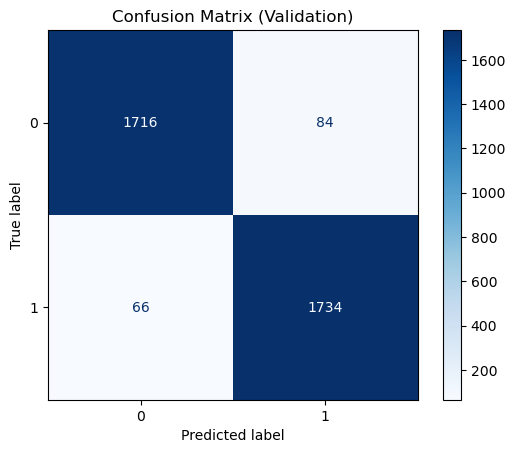

In [15]:
# H0 — Confusion matrix on validation set

cm = confusion_matrix(y_val, val_preds, labels=[0,1])

print("Confusion Matrix (Validation):")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix (Validation)")
plt.show()

271 “missed matches” (false negatives).  
40 “wrongly flagged as matches” (false positives).

## H1 — Extract misclassifications & show top 5

In [16]:
# Get validation predictions (you already computed val_probs/val_preds in Step 6)
val_errors_mask = (val_preds != y_val)
val_errors_idx = np.where(val_errors_mask)[0]

# Build a dataframe for inspection
val_review_df = pd.DataFrame({
    "prob_1": val_probs,                 # P(y=1 | x)
    "pred": val_preds,
    "true": y_val
})
# attach original columns for context
columns_to_show = [
    "first_name_left","last_name_left","country_left",
    "first_name_right","last_name_right","country_right"
]
val_review_df = pd.concat([val_review_df, val_df.reset_index(drop=True)[columns_to_show]], axis=1)

# Keep only errors
val_review_df = val_review_df.iloc[val_errors_idx].copy()

# Rank errors: “most confident but wrong” first (distance from 0.5 is large)
val_review_df["conf_dist"] = (val_review_df["prob_1"] - 0.5).abs()

# Show top-5 problematic cases
top5 = val_review_df.sort_values("conf_dist", ascending=False).head(5)
top5.reset_index(drop=True)

,prob_1,pred,true,first_name_left,last_name_left,country_left,first_name_right,last_name_right,country_right,conf_dist
0,0.0,0,1,Laura,López,Spain,Luara,Lepz,Spain,0.5
1,1.0,1,0,Sergio,Sánchez,Spain,Lucía,Sánchez,Spain,0.5
2,1.0,1,0,Giulia,Esposito,Italy,Giorgia,Esposito,Italy,0.5
3,1.0,1,0,Tobias,Müller,Germany,Tobia,Gross,Germany,0.5
4,1.0,1,0,María,Sánchez,Spain,Jesús,Sánchez,Spain,0.5


## H2 — Map them to correct values (simulate human labels)

In [17]:
# For the PoC, we use the ground-truth 'true' column as the “human-provided” label.

MAX_ERROR_FRACTION = 0.7  # e.g., at most 70% of the batch are errors

# Build indices for errors and correct predictions
y_val_np = np.asarray(y_val)
val_errors_mask = (val_preds != y_val_np)

# Indices of errors per class
err_0_idx = np.where(val_errors_mask & (y_val_np == 0))[0]
err_1_idx = np.where(val_errors_mask & (y_val_np == 1))[0]

# Indices of correctly classified examples per class
corr_0_pool = np.where((~val_errors_mask) & (y_val_np == 0))[0]
corr_1_pool = np.where((~val_errors_mask) & (y_val_np == 1))[0]

rng = np.random.default_rng(SEED)

# Choose a target number per class.
# Option A: use the smaller available total to avoid running out.
max_per_class_0 = len(err_0_idx) + len(corr_0_pool)
max_per_class_1 = len(err_1_idx) + len(corr_1_pool)
target_per_class = min(max_per_class_0, max_per_class_1, 200)  # cap at 200 per class, for example

def build_class_batch(err_idx, corr_pool, target_n):
    """Always include as many errors as possible up to target_n,
    then fill with correct examples if needed."""
    err_idx = np.asarray(err_idx)
    corr_pool = np.asarray(corr_pool)

    # desired number of errors, but not more than we actually have
    max_err_allowed = int(target_n * MAX_ERROR_FRACTION)
    n_err = min(len(err_idx), max_err_allowed)
    n_corr = target_n - n_err

    chosen_err = rng.choice(err_idx, size=n_err, replace=False) if n_err > 0 else np.array([], dtype=int)
    chosen_corr = rng.choice(corr_pool, size=n_corr, replace=False) if n_corr > 0 else np.array([], dtype=int)

    return np.concatenate([chosen_err, chosen_corr])

human_idx_0 = build_class_batch(err_0_idx, corr_0_pool, target_per_class)
human_idx_1 = build_class_batch(err_1_idx, corr_1_pool, target_per_class)

# Final balanced human batch indices
human_idx = np.concatenate([human_idx_0, human_idx_1])
rng.shuffle(human_idx)

X_human = X_val_sparse[human_idx]
y_human = y_val_np[human_idx]

err_0_contrib = np.intersect1d(human_idx_0, err_0_idx).size
corr_0_contrib = human_idx_0.size - err_0_contrib

err_1_contrib = np.intersect1d(human_idx_1, err_1_idx).size
corr_1_contrib = human_idx_1.size - err_1_contrib

print(
    f"Human batch size: {len(human_idx)} "
    f"| Class-0: total={len(human_idx_0)}, errors={err_0_contrib}, correct={corr_0_contrib} "
    f"| Class-1: total={len(human_idx_1)}, errors={err_1_contrib}, correct={corr_1_contrib}"
)

Human batch size: 400 | Class-0: total=200, errors=84, correct=116 | Class-1: total=200, errors=66, correct=134


## H3 — Feedback to the existing model

In [18]:
# # IMPORTANT: incremental update, not re-training from scratch.
# # SGDClassifier supports partial_fit for warm updates.

# small_w = np.full(shape=len(y_human), fill_value=0.1, dtype=float)
# clf.partial_fit(X_human, y_human, sample_weight=small_w)

# print("Model updated with balanced human batch (small step).")

In [19]:
# # IMPORTANT: Re-training from scratch.
# # RandomForest and LogisticRegression do not support partial_fit for warm updates.
from scipy import sparse
import numpy as np

# Combine original train data with human batch
X_train_ext = sparse.vstack([X_train_sparse, X_human])
y_train_ext = np.concatenate([y_train, y_human])

# Retrain Logistic Regression on extended data
clf.fit(X_train_ext, y_train_ext)

print("Model retrained on train + human batch (HITL update).")

Model retrained on train + human batch (HITL update).


## H4 — Validate again

In [20]:
# Re-score test (unseen) to measure true generalization change
test_probs2 = clf.predict_proba(X_test_sparse)[:, 1]
test_preds2 = (test_probs2 >= 0.5).astype(int)

print("\n=== Test (after human update) ===")
print(classification_report(y_test, test_preds2, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, test_probs2))
print("PR-AUC :", average_precision_score(y_test, test_probs2))


=== Test (after human update) ===
              precision    recall  f1-score   support

           0      0.964     0.953     0.958      1800
           1      0.953     0.964     0.959      1800

    accuracy                          0.959      3600
   macro avg      0.959     0.959     0.959      3600
weighted avg      0.959     0.959     0.959      3600

ROC-AUC: 0.9824577160493827
PR-AUC : 0.9696568115356885


## H5 — Confusion Matrix

Confusion Matrix (Test, after human update):
[[1716   84]
 [  70 1730]]


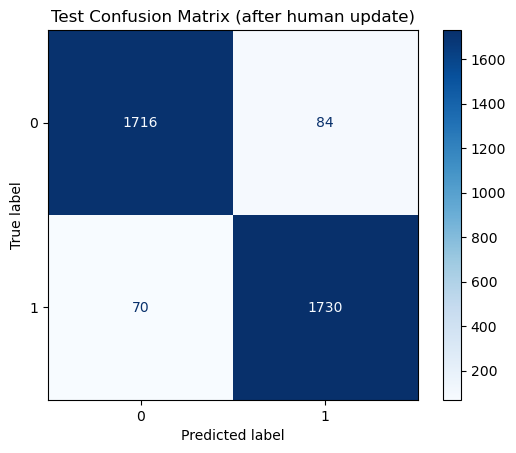

In [21]:
# H5 — Confusion Matrices after human feedback update

# Validation CM
cm_test = confusion_matrix(y_test, test_preds, labels=[0,1])
print("Confusion Matrix (Test, after human update):")
print(cm_test)

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0,1])
disp_test.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Test Confusion Matrix (after human update)")
plt.show()

**Observations**:  
- Despite accuracy increased, it became less conservative which is not desired in our use case.  
- This is highly dependant on the approach and training data.  
- In this case it happened because the human in the loop biased the training towards the opposite direction, shifting toward predicting more matches (1) and produced lots of false positives.

- The error batch (which was validated by the human in the loop) had:
  - 311 errors (all misclassified),
  - 40 correctly classified 0s,
  - 271 correctly classified 1s.

- That means the update data was dominated by class 1 (matches):
  - Only ~12% of the batch was class 0 (40 / 311+40+271).
  - Almost 88% was class 1.

- When you `partial_fit` with this distribution, the model “learns” that class 1 is much more likely → it becomes overconfident in predicting matches.

**Result**:  
  - False negatives dropped (good),  
  - But false positives skyrocketed (bad).

# LLM Matching

## L1 — Imports & LLM config

In [18]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
import os
import json
import uuid
from textwrap import shorten

In [19]:
llm = ChatOpenAI(
    model="gpt-5",
    temperature=0.1,
    openai_api_key=os.getenv("OPENAI_API_KEY"),
)
emb = OpenAIEmbeddings(openai_api_key=os.getenv("OPENAI_API_KEY"))

## L2 — Build RAG index from train + val

In [20]:
# L2 — Build RAG index (train + val only)
def row_to_case_text(r):
    # a compact canonical text for similarity search
    l = f"FIRST_LEFT:{r.first_name_left} LAST_LEFT:{r.last_name_left} COUNTRY_LEFT:{r.country_left}"
    rt = f"FIRST_RIGHT:{r.first_name_right} LAST_RIGHT:{r.last_name_right} COUNTRY_RIGHT:{r.country_right}"
    return f"{l} || {rt}"

def make_docs(df, split_name):
    docs = []
    for r in df.itertuples(index=False):
        text = row_to_case_text(r)
        meta = {
            "label": int(r.label),
            "split": split_name,
            "first_name_left": r.first_name_left,
            "last_name_left": r.last_name_left,
            "country_left": r.country_left,
            "first_name_right": r.first_name_right,
            "last_name_right": r.last_name_right,
            "country_right": r.country_right
        }
        docs.append(Document(page_content=text, metadata=meta))
    return docs

train_docs = make_docs(train_df, "train")
val_docs   = make_docs(val_df,   "val")

# Vector store (FAISS is simple & fast for local PoC)
vs = FAISS.from_documents(train_docs + val_docs, emb)
retriever = vs.as_retriever(search_kwargs={"k": 8})
print("RAG index built. #docs:", len(train_docs) + len(val_docs))

RAG index built. #docs: 20400


## L3 — Prompt with strict JSON output and token estimator

In [21]:
# L3 — Prompt, parser, retrieval config, and cache (for batched LLM evaluation)

# ---- Prompt (batched) ----
PROMPT_MULTI = """You are an entity-matching expert. You will receive multiple independent items.
Each item contains two person records and some labeled exemplars (memory). Decide if the two records
refer to the same person (1) or not (0), and produce probabilities and a short rationale.

Rules:
- Respond with a SINGLE JSON array.
- For each input item, return an object: 
  {{
    "id": "<the id we provided>",
    "match_label": 0 or 1,
    "match_probability": number in [0,1],
    "rationale": "one or two short sentences"
  }}
- Do not include any extra keys or extra text outside the JSON.

Consider:
- transliterations (ü→ue, ä→ae, ö→oe, ß→ss), diacritics (á/à/â),
- common typos/transpositions,
- country consistency (same country increases likelihood).

INPUT ITEMS:
{items}
"""

# ---- JSON parser for outputs ----
parser = JsonOutputParser()  # robust JSON parsing

# ---- RAG + batching knobs (cost control) ----
BATCH_SIZE = 20      # number of pairs per LLM call
K_RETRIEVE = 3       # top-k exemplars per item (smaller -> cheaper)
MAX_EX_CHAR = 400    # truncate each exemplar line to control tokens

# ---- Simple in-memory cache for retrieval results ----
_retrieval_cache = {}

def cached_retrieve(query: str):
    """Retrieve labeled exemplars with caching (uses LangChain retriever)."""
    if query in _retrieval_cache:
        return _retrieval_cache[query]
    docs = retriever.invoke(query)  # modern LC API
    _retrieval_cache[query] = docs
    return docs

def format_exemplars_for_query(query: str) -> str:
    """Format and truncate retrieved exemplars for prompt inclusion."""
    docs = cached_retrieve(query)
    lines = []
    for d in docs[:K_RETRIEVE]:
        lbl = d.metadata.get("label", 0)
        txt = d.page_content
        lines.append(f"- LABEL:{lbl} | {shorten(txt, width=MAX_EX_CHAR, placeholder='…')}")
    return "\n".join(lines) if lines else "- (no exemplars retrieved)"

    # Try to use tiktoken if available; otherwise fallback to a simple heuristic (~4 chars per token)
try:
    import tiktoken
    _ENC = tiktoken.get_encoding("cl100k_base")  # good default for modern GPT-family models
    def estimate_tokens(text: str) -> int:
        return len(_ENC.encode(text))
except Exception:
    def estimate_tokens(text: str) -> int:
        # Rough heuristic: ~4 chars per token (safe for budgeting)
        return max(1, int(len(text) / 4))

# Soft budget knobs (tune to your model/context window)
MAX_INPUT_TOKENS_PER_BATCH = 20000   # soft limit for prompt input tokens
TOKEN_BUDGET_VERBOSE = True          # print batch token estimates

def estimate_batch_tokens(items_payload: list[str], prompt_template: str = PROMPT_MULTI) -> int:
    """Estimate token count for the full batch prompt."""
    joined = "\n\n".join(items_payload)
    prompt_text = prompt_template.format(items=joined)
    return estimate_tokens(prompt_text)

## L4 — Batch-pair classifier with retrieval

In [22]:
# L4 — Sampler (stratified/uncertainty) + batched classifier

import uuid
import numpy as np
import pandas as pd

def stratified_sample(df: pd.DataFrame, n_per_class: int = 100, seed: int = 42) -> pd.DataFrame:
    """Take a balanced subset (n_per_class per label)."""
    out = []
    for y in (0, 1):
        block = df[df["label"].astype(int) == y]
        k = min(n_per_class, len(block))
        out.append(block.sample(n=k, random_state=seed))
    return pd.concat(out, axis=0).sample(frac=1.0, random_state=seed).reset_index(drop=True)

def uncertainty_sample(df: pd.DataFrame, probs: np.ndarray, low: float = 0.4, high: float = 0.6, max_n: int = 200, seed: int = 42) -> pd.DataFrame:
    """Select 'gray zone' items by probability in [low, high]. Falls back to random if not enough."""
    mask = (probs >= low) & (probs <= high)
    sub = df.loc[mask]
    if len(sub) > max_n:
        sub = sub.sample(n=max_n, random_state=seed)
    elif len(sub) < max_n:
        # top-up with stratified random to reach max_n
        need = max_n - len(sub)
        rest = df.loc[~mask]
        add = rest.sample(n=min(need, len(rest)), random_state=seed)
        sub = pd.concat([sub, add], axis=0)
    return sub.sample(frac=1.0, random_state=seed).reset_index(drop=True)

def row_to_case_text(r):
    """Compact text used for retrieval similarity."""
    l = f"FIRST_LEFT:{r.first_name_left} LAST_LEFT:{r.last_name_left} COUNTRY_LEFT:{r.country_left}"
    rt = f"FIRST_RIGHT:{r.first_name_right} LAST_RIGHT:{r.last_name_right} COUNTRY_RIGHT:{r.country_right}"
    return f"{l} || {rt}"

def _format_single_item(item_id, row, exemplars_txt):
    return f"""
ID: {item_id}
PAIR:
  FIRST_LEFT: {row.first_name_left}
  LAST_LEFT: {row.last_name_left}
  COUNTRY_LEFT: {row.country_left}
  FIRST_RIGHT: {row.first_name_right}
  LAST_RIGHT: {row.last_name_right}
  COUNTRY_RIGHT: {row.country_right}
EXEMPLARS (labeled):
{exemplars_txt}
""".strip()

def llm_classify_batch(rows):
    """Classify a list of NamedTuple rows in one LLM call; returns list of dicts with id/label/prob/rationale."""
    items_payload = []
    id_list = []
    for r in rows:
        item_id = str(uuid.uuid4())
        id_list.append(item_id)
        q = row_to_case_text(r)
        exemplars_txt = format_exemplars_for_query(q)
        items_payload.append(_format_single_item(item_id, r, exemplars_txt))

    # --- Token budgeting: estimate before sending ---
    est_tokens = estimate_batch_tokens(items_payload, PROMPT_MULTI)
    if TOKEN_BUDGET_VERBOSE:
        print(f"[Batch size={len(rows)}] Estimated input tokens ≈ {est_tokens:,} "
              f"(limit ~{MAX_INPUT_TOKENS_PER_BATCH:,}).")

    if est_tokens > MAX_INPUT_TOKENS_PER_BATCH:
        print("Estimated tokens exceed soft budget. Consider: "
              "lowering K_RETRIEVE, reducing MAX_EX_CHAR, or decreasing BATCH_SIZE.")

    # Build and send the batch prompt
    prompt_text = PROMPT_MULTI.format(items="\n\n".join(items_payload))
    resp = llm.invoke([{"role": "user", "content": prompt_text}]).content

    # Parse strict JSON array (graceful fallback on parse error)
    try:
        data = json.loads(resp)
        id_to_obj = {
            str(o.get("id", "")): {
                "id": str(o.get("id", "")),
                "match_label": int(o.get("match_label", 0)),
                "match_probability": float(o.get("match_probability", 0.5)),
                "rationale": str(o.get("rationale", ""))[:500],
            }
            for o in data
        }
        return [id_to_obj.get(i, {"id": i, "match_label": 0, "match_probability": 0.5, "rationale": "missing"}) for i in id_list]
    except Exception as e:
        return [{"id": i, "match_label": 0, "match_probability": 0.5, "rationale": f"parse_error:{type(e).__name__}"} for i in id_list]

## L5 — Run on test and evaluate

In [23]:
# L5 — Choose subset, run batched evaluation, report metrics

# ---- Choose evaluation subset ----
EVAL_MODE = "uncertainty"   # "stratified" or "uncertainty"
N_PER_CLASS = 100          # used if EVAL_MODE="stratified"  -> total ~200
UNC_LOW, UNC_HIGH = 0.4, 0.6
UNC_MAX_N = 200            # used if EVAL_MODE="uncertainty"

test_supervised_probs = None  # set to array to use "uncertainty" mode
# We can provide the uncertain cases from the supervised model to have a side to side comparison. Uncomment following line
# Note that here we will pass predictions after the Human in the Loop process.
test_supervised_probs = clf.predict_proba(X_test_sparse)[:, 1]


if EVAL_MODE == "uncertainty" and test_supervised_probs is None:
    print("Uncertainty mode selected but no supervised probs found; falling back to stratified.")
    EVAL_MODE = "stratified"

if EVAL_MODE == "stratified":
    eval_df = stratified_sample(test_df, n_per_class=N_PER_CLASS, seed=SEED)
else:
    eval_df = uncertainty_sample(test_df, probs=test_supervised_probs, low=UNC_LOW, high=UNC_HIGH, max_n=UNC_MAX_N, seed=SEED)

print(f"Evaluation subset size: {len(eval_df)} (mode={EVAL_MODE})")

# ---- Run LLM classifier in batches of 20 ----
rows = list(eval_df.itertuples(index=False))
pred_labels, pred_probs, rationales = [], [], []

for start in range(0, len(rows), BATCH_SIZE):
    chunk = rows[start:start+BATCH_SIZE]
    results = llm_classify_batch(chunk)
    for res in results:
        pred_labels.append(int(res["match_label"]))
        pred_probs.append(float(res["match_probability"]))
        rationales.append(res.get("rationale", ""))

y_true = eval_df["label"].astype(int).to_numpy()
y_pred = np.array(pred_labels, dtype=int)
y_prob = np.array(pred_probs, dtype=float)

Evaluation subset size: 200 (mode=uncertainty)
[Batch size=20] Estimated input tokens ≈ 4,020 (limit ~20,000).
[Batch size=20] Estimated input tokens ≈ 3,983 (limit ~20,000).
[Batch size=20] Estimated input tokens ≈ 4,009 (limit ~20,000).
[Batch size=20] Estimated input tokens ≈ 4,017 (limit ~20,000).
[Batch size=20] Estimated input tokens ≈ 4,040 (limit ~20,000).
[Batch size=20] Estimated input tokens ≈ 3,997 (limit ~20,000).
[Batch size=20] Estimated input tokens ≈ 4,024 (limit ~20,000).
[Batch size=20] Estimated input tokens ≈ 3,990 (limit ~20,000).
[Batch size=20] Estimated input tokens ≈ 4,043 (limit ~20,000).
[Batch size=20] Estimated input tokens ≈ 4,005 (limit ~20,000).


=== LLM (RAG, batched) — Evaluation subset ===
              precision    recall  f1-score   support

           0      0.994     0.994     0.994       180
           1      0.950     0.950     0.950        20

    accuracy                          0.990       200
   macro avg      0.972     0.972     0.972       200
weighted avg      0.990     0.990     0.990       200

ROC-AUC: 0.9969444444444444
PR-AUC : 0.9625203116456986
Confusion matrix:
 [[179   1]
 [  1  19]]


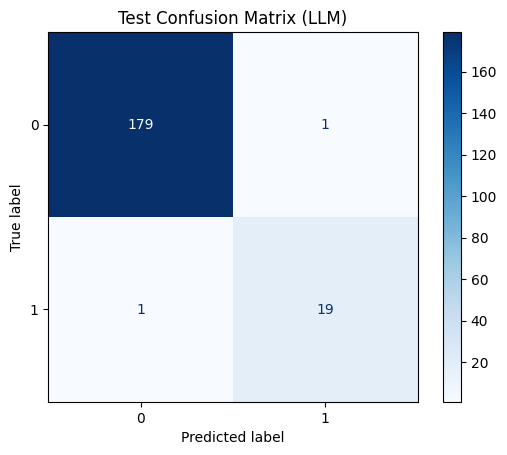

In [24]:
# ---- Report ----
print("=== LLM (RAG, batched) — Evaluation subset ===")
print(classification_report(y_true, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_true, y_prob))
print("PR-AUC :", average_precision_score(y_true, y_prob))

cm_llm = confusion_matrix(y_true, y_pred, labels=[0,1])
print("Confusion matrix:\n", cm_llm)

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_llm, display_labels=[0,1])
disp_test.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Test Confusion Matrix (LLM)")
plt.show()